In [ ]:
!pip install emoji

In [ ]:
import pandas as pd
import numpy as np
import re
import emoji
import nltk
import joblib
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Load the Excel file using pandas
file_path = '/content/drive/MyDrive/AIML/sentemental_analysis/Dataset_changed.csv'

# Read the Excel file
df = pd.read_csv(file_path)

# To display the entire DataFrame, set the maximum display rows option
display(df)

,TEXT,REACTION
0,Good morning! 🌞,positive
1,Thanks a lot! 🙏,positive
2,Thank you so much. 😊,negative
3,Stop it 😠,negative
4,"Ugh, not again. 🙄",negative
...,...,...
12535,A bed of roses,negative
12536,Tickled pink,negative
12537,Bed of roses,negative
12538,Once in a blue moon,negative


In [ ]:
# Normalize the sentiment labels to lowercase and fix typos
def clean_sentiment_label(label):
    label = label.strip().lower()  # make lowercase and remove extra spaces
    if label == "postive" or label == "Postive":         # correct typo
        return "positive"
    elif label == "negetive" or label == "Negative" or label == "negative":      # just in case (if typo)
        return "negative"
    elif label == "neutral" or label == "Neutral":
        return "neutral"
    else:
        return label

# Apply the cleaning function
df['Sentiment'] = df['REACTION'].apply(clean_sentiment_label)

# Verify the unique labels
print("Unique Sentiments:", df['Sentiment'].unique())

print(df['Sentiment'].value_counts())

# STEP 1: Drop rows with null values
df.dropna(inplace=True)

# STEP 2: Define a cleaning function
def clean_text(text):
    # Convert emojis to text (e.g., 😊 -> :smiling_face_with_smiling_eyes:)
    text = emoji.demojize(text)

    # Lowercase the text
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove punctuation and special characters (except emojis which are now text)
    text = re.sub(r'[^a-zA-Z0-9: ]', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# STEP 3: Apply the cleaning function to the text column
df['clean_text'] = df['TEXT'].apply(clean_text)

# Show a few cleaned examples
print(df[['TEXT', 'clean_text']].head())

Unique Sentiments: ['positive' 'negative' 'neutral']
Sentiment
positive    6005
neutral     3438
negative    3097
Name: count, dtype: int64
                   TEXT                                      clean_text
0       Good morning! 🌞                      good morning :sunwithface:
1       Thanks a lot! 🙏                      thanks a lot :foldedhands:
2  Thank you so much. 😊  thank you so much :smilingfacewithsmilingeyes:
3             Stop it 😠                             stop it :angryface:
4     Ugh, not again. 🙄             ugh not again :facewithrollingeyes:


Accuracy: 0.7946570972886763

Classification Report:
               precision    recall  f1-score   support

    negative       0.78      0.76      0.77       636
     neutral       0.68      0.81      0.74       697
    positive       0.89      0.80      0.85      1175

    accuracy                           0.79      2508
   macro avg       0.78      0.79      0.78      2508
weighted avg       0.81      0.79      0.80      2508



<Figure size 800x600 with 0 Axes>

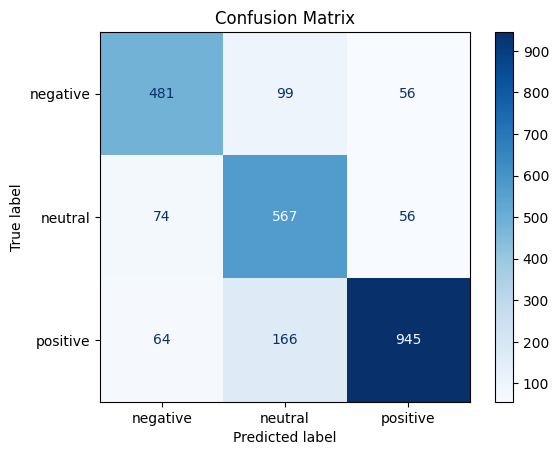

In [ ]:
# STEP 1: Feature Extraction using TF-IDF
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))  # Convert text to vector (bag of words with importance)
X = tfidf.fit_transform(df['clean_text']).toarray()  # Features
y = df['Sentiment']  # Labels (e.g., Positive, Negative, Neutral)

# STEP 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# STEP 3: Train the SVM model
svm_model = SVC(kernel='linear', class_weight='balanced', C=1.0)
svm_model.fit(X_train, y_train)

# STEP 4: Make predictions
y_pred = svm_model.predict(X_test)

# STEP 5: Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# STEP 6: Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=svm_model.classes_)  # Confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
def get_sentiment(text, model, vectorizer):
    clean_input = text.lower()
    input_vector = vectorizer.transform([clean_input]).toarray()
    prediction = model.predict(input_vector)[0]

    # Return the predicted sentiment word
    return prediction

# Interactive part
user_input = input("Enter your message: ")
predicted_sentiment = get_sentiment(user_input, svm_model, tfidf)

print("\nPredicted Sentiment:", predicted_sentiment)

Enter your message: i am feeling blue

Predicted Sentiment: negative


In [ ]:
joblib.dump(svm_model, 'svm_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']